Ноутбук по переводу UMLS CUI в pt meddra и переводу на рус. англоязычных датасетов, а также подсчету статистики

In [1]:
import os
import xml.etree.ElementTree as ET
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import jsonlines
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
nltk.download('punkt')

In [25]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/romanrybka/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

<h2>Инициализация необходимых объектов, функций, классов</h2>

<h3>Маппинг кодов с концептами pt</h3>

In [2]:
class MeddraHelper():
    def __init__(self, meddra_path_pt, meddra_path_llt, umls_path, lang='ENG'):
        assert lang in ['ENG', 'RUS'], "Choose 'RUS' or 'ENG'"
        self.meddra_path_pt = meddra_path_pt
        self.meddra_path_llt = meddra_path_llt
        self.umls_path = umls_path
        self.language = lang
        self.ptcodes = []
        self.ptcode_to_pt = {}
        self.pt_to_ptcode = {}
        self.umlscode_to_ptcode = {}
        self.umlscode_to_pt = {}
        self.umlscode_to_lltcode = {}
        self.umlscode_to_llt = {}
        self.lltcode_to_ptcode = {}
        self.llt_to_lltcode = {}
        self.Load()

    def Load(self):
        """
        собираем из медры только то, что надо, а именно:
        - все пт коды для быстрой проверки, является ли найденный где-то код PT кодом
        """
        with open(self.meddra_path_pt, "r") as f:
            for pt_line in f:
                pt_line = pt_line.split("$")
                self.ptcodes.append(pt_line[0])
                self.ptcode_to_pt[pt_line[0]] = pt_line[1]
                self.pt_to_ptcode[pt_line[1]] = pt_line[0]
                
        with open(self.meddra_path_llt, "r") as f:
            for llt_line in f:
                llt_line = llt_line.split("$")
                self.lltcode_to_ptcode[llt_line[0]] = llt_line[2]
                self.llt_to_lltcode[llt_line[1]] = llt_line[0]
        
        with open(self.umls_path, "r") as f: #./Data/ExternalMRCONSO.RRF 12 и 13 строки
            for umls_line in f:
                umls_line_values = umls_line.split('|')
                umls_meddra_flag, umls_meddra_pt_or_llt_flag, lang_flag = umls_line_values[11], umls_line_values[12], umls_line_values[1] 
                umls_meddra_flag = True if umls_meddra_flag=='MDR' else False
                umls_meddra_pt_flag = True if umls_meddra_pt_or_llt_flag=='PT' else False
                umls_meddra_llt_flag = True if umls_meddra_pt_or_llt_flag=='LLT' else False
                lang_flag = True if self.language == lang_flag else False
                if not umls_meddra_flag or not (umls_meddra_pt_flag or umls_meddra_llt_flag)  or not lang_flag:
                    continue
                umls_code = umls_line_values[0]
                meddra_code = umls_line_values[10] 
                meddra_term = umls_line_values[14]
                if umls_meddra_pt_flag:
                    self.umlscode_to_ptcode[umls_code] = meddra_code
                    self.umlscode_to_pt[umls_code] = meddra_term
                if umls_meddra_llt_flag:
                    self.umlscode_to_lltcode[umls_code] = meddra_code
                    self.umlscode_to_llt[umls_code] = meddra_term
                    
    def force_umlscode_to_ptcode(self, umls_code):
        #если код umls не приводится сразу к pt
        #тогда пробуем привести к llt, затем к pt
        if umls_code in self.umlscode_to_ptcode.keys():
            return self.umlscode_to_ptcode[umls_code]
        elif umls_code in self.umlscode_to_lltcode.keys():
            return self.lltcode_to_ptcode[self.umlscode_to_lltcode[umls_code]]
        else:
            return None

<h3>Функции по сбору статистики и лемматизации</h3>

In [3]:
import re

def nltk_pos_tagger(word):
    nltk_tag = nltk.pos_tag([word])[0][1]
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
    
def get_word_lemma(word):
    tag = nltk_pos_tagger(word)
    if tag:
        return lemmatizer.lemmatize(word.lower(), tag)
    else:
        return lemmatizer.lemmatize(word.lower())
    
def lemmatize_phrase(phrase):
    words = nltk.word_tokenize(phrase)
    lemmas = list(map(get_word_lemma, words)) 
    return ' '.join(lemmas)
    
def count_representativeness(pt_ids, phrases, lemmatize=True):
    stat_dict = {k: set() for k in set(pt_ids)}
    for pt_id, phrase in zip(pt_ids, phrases):
        if lemmatize:
            stat_dict[pt_id].add(re.sub('\s+', ' ', lemmatize_phrase(phrase).lower()))
        else:
            stat_dict[pt_id].add(re.sub('\s+', ' ', phrase.lower()))
    count_stat_dict = {k: len(v) for k, v in stat_dict.items()}
    return count_stat_dict

<h3>Функции по визуализации</h3>

In [4]:
def count_uniq_codes_and_phrases(all_pt_phrases, lemmatize_phrases=True):
    print('num uniq meddra codes: %s'%len(stat_d))
    if lemmatize_phrases:
        print('num uniq phrases: %s'%len(set(map(lambda x: re.sub('\s+', ' ', lemmatize_phrase(x).lower()), all_pt_phrases))))
    else:
        print('num uniq phrases: %s'%len(set(map(lambda x: re.sub('\s+', ' ', x.lower()), all_pt_phrases))))

def avg_num_phrases_per_code(stat_d):
    print('avg num phrases per code: %s'%(sum(list(stat_d.values()))/len(stat_d)))
    
def get_hist(stat_d, n_bins, hist_fname, figsize=(6,8), xlim = None, ylim = None):
    if n_bins == 'auto':
        max_uniq_phrases = max(list(stat_d.values()))
        n_bins = max_uniq_phrases-1
    plt.figure(figsize=figsize)
    N, bins, patches = plt.hist(list(stat_d.values()), bins = n_bins)
    if xlim:
        plt.xlim(left = xlim[0])
        plt.xlim(right = xlim[1])
    if ylim:
        plt.ylim(left=ylim[0])
        plt.ylim(right=ylim[1])
    plt.xlabel('Кол-во уникальных лемматизированных фраз на 1 pt код')
    plt.ylabel('Кол-во pt кодов в корпусе')
    plt.savefig(hist_fname)
    plt.show()
    return (N, bins, patches)

def get_most_freq_codes(bins, stat_d, num_last_bins = 2):
    #num_last_bins - сколько колонок взять с конца гистограммы
    freq_max_section = np.trunc((bins[-(num_last_bins+1)], bins[-1]))
    return [k for k,v in stat_d.items() if v in freq_max_section]

<h3>Глобальные объекты и переменные</h3>

In [5]:
ALL_AVAILABLE_PTCODES = set()

In [6]:
mh_en = MeddraHelper(meddra_path_pt = './External/pt_en.asc', 
                     meddra_path_llt = './External/llt_en.asc',
                     umls_path = './External/MRCONSO.RRF')
mh_rus = MeddraHelper(meddra_path_pt = './External/pt_rus.asc', 
                      meddra_path_llt = './External/llt_rus.asc',
                      lang = 'RUS', 
                      umls_path = './External/MRCONSO.RRF')
lemmatizer = WordNetLemmatizer()

In [7]:
FULL_STAT = {k: 0 for k in mh_en.ptcodes}

<h2>Обработка датасетов</h2>

<h3>TAC 2017</h3>

In [8]:
#без контекста, только фразы c нормализацией
data_dir = './Raw/TAC 2017/train_xml'

def list_and_filter_dir(data_dir):
    for file in os.listdir(data_dir):
        if file[0]=='.' or file.find('xml')<0:
            continue
        yield file
        

all_pt_ids = []
all_pt_terms = []
all_pt_phrases = []

for file in list_and_filter_dir(data_dir):
    tree = ET.parse(os.path.join(data_dir, file))
    root = tree.getroot()
    
    pt_ids = []
    pt_terms = []
    pt_phrases = []
        
    for norm_mention in root.findall('./Reactions/Reaction'):
        for meddra_code in norm_mention.findall('Normalization'):
            meddra_pt = meddra_code.get('meddra_pt')
            meddra_pt_id = meddra_code.get('meddra_pt_id')
            if meddra_pt is None or meddra_pt_id is None:
                continue
            pt_ids.append(meddra_pt_id)
            pt_terms.append(meddra_pt)
            pt_phrases.append(norm_mention.get('str'))
            
    all_pt_ids.extend(pt_ids)
    all_pt_terms.extend(pt_terms)
    all_pt_phrases.extend(pt_phrases)
    
#print(all_pt_ids[500:508])
#print(all_pt_terms[500:508])
#print(all_pt_phrases[500:508])

stat_d = count_representativeness(all_pt_ids, all_pt_phrases)
stat_d = {k: v for k, v in stat_d.items() if k in mh_en.ptcodes}
#pprint(stat_d)

In [9]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 7045


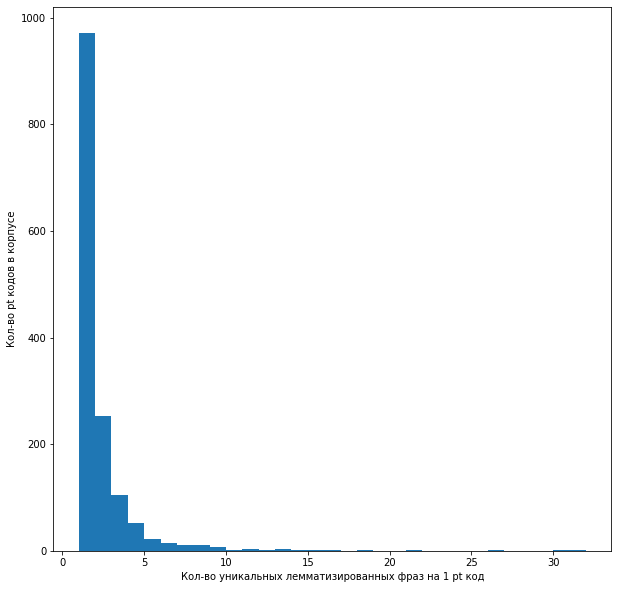

num uniq meddra codes: 1464
num uniq phrases: 2731
avg num phrases per code: 1.8599726775956285


In [69]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', figsize = (10, 10), hist_fname='TAC 2017 (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

In [138]:
len(bins)

34

In [74]:
freq_codes = get_most_freq_codes(bins, stat_d, num_last_bins = 2)

In [82]:
pprint(list(map(lambda x: mh.ptcode_to_pt[x], freq_codes)), indent=1)

['Alanine aminotransferase increased']


In [128]:
for k in stat_d:  
    FULL_STAT[k]+=stat_d[k]
    
ALL_AVAILABLE_PTCODES.update(set(stat_d.keys()))

<h3>SMM4H 2017</h3>

In [1]:
data_dir = './Raw/SMM4H_2017/'
with open(data_dir + 'train.txt') as tr, open(data_dir + 'test.txt') as ts:
    train_phrases = []
    train_terms = []
    train_codes = []
    test_phrases = []
    test_terms = []
    test_codes = []
    for pair in tr.read().split('\n'):
        if pair=='':
            continue
        row_inf = pair.split('\t')
        if row_inf[2] in mh_en.ptcodes:
            train_phrases.append(row_inf[1])
            train_terms.append(mh_en.ptcode_to_pt[row_inf[2]])
            train_codes.append(row_inf[2])
    for pair in ts.read().split('\n'):
        if pair=='':
            continue
        row_inf = pair.split('\t')
        if row_inf[2] in mh_en.ptcodes:
            test_phrases.append(row_inf[1])
            test_terms.append(mh_en.ptcode_to_pt[row_inf[2]])
            test_codes.append(row_inf[2])

all_pt_ids = train_codes + test_codes
all_pt_phrases = train_phrases + test_phrases
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

NameError: name 'mh_en' is not defined

In [11]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 9121


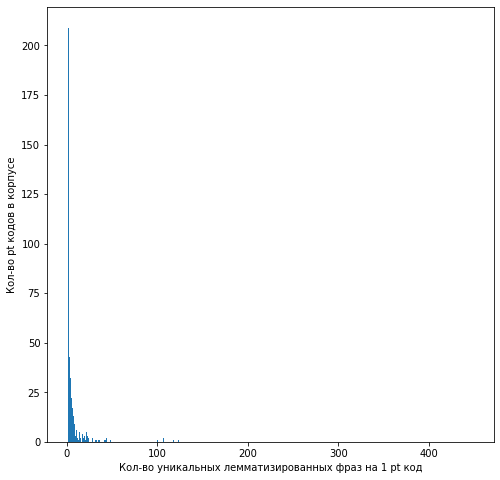

num uniq meddra codes: 497
num uniq phrases: 3313
avg num phrases per code: 6.710261569416499


In [71]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(8,8), \
                           hist_fname='SMM4H 2017 (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

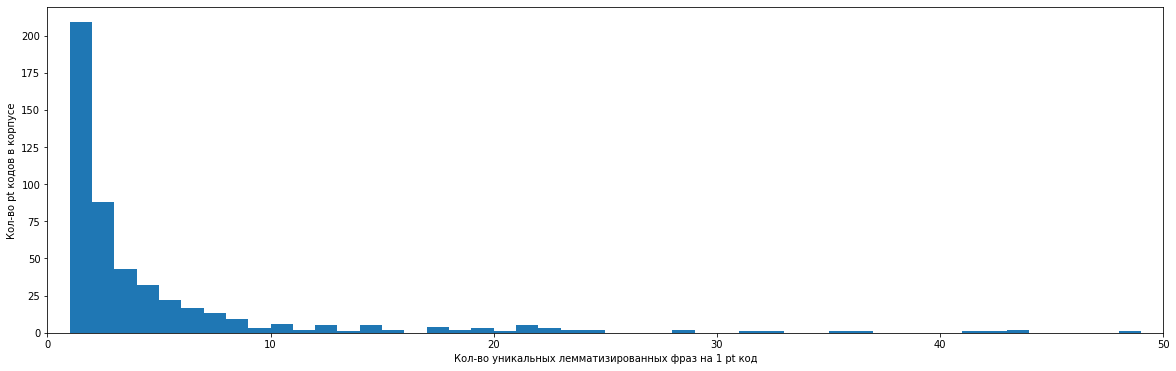

In [33]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,6), \
                           xlim = (0,50), \
                           hist_fname='SMM4H 2017 (with lemmatization) xlim_right 50.png')

In [133]:
for k in stat_d:  
    FULL_STAT[k]+=stat_d[k]
    
ALL_AVAILABLE_PTCODES.update(set(stat_d.keys()))

<h3>Наш корпус RDR</h3>

In [12]:
ds = []
with jsonlines.open('./Raw/medNorm_16022022.jsonlines') as reader:
    for obj in reader:
        ds.append(obj)

In [36]:
list(mh_rus.pt_to_ptcode.keys())[0]

'Недостаточность 11-бета-гидроксилазы'

In [13]:
all_pt_ids = []
all_pt_phrases = []
for review in ds:
    for ent in review['objects']['MedEntity']:
        if 'MedDRA' in ent.keys() and ent['MedDRA']!='':
            try:
                all_pt_ids.append(mh_rus.pt_to_ptcode[ent['MedDRA'].split('|')[0]])
                all_pt_phrases.append(ent['text'])
            except KeyError:
                log_markup_errors.append({'review_id': review['meta']['fileName'], 'entity_id': ent['xmiID']})
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

In [14]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 11908


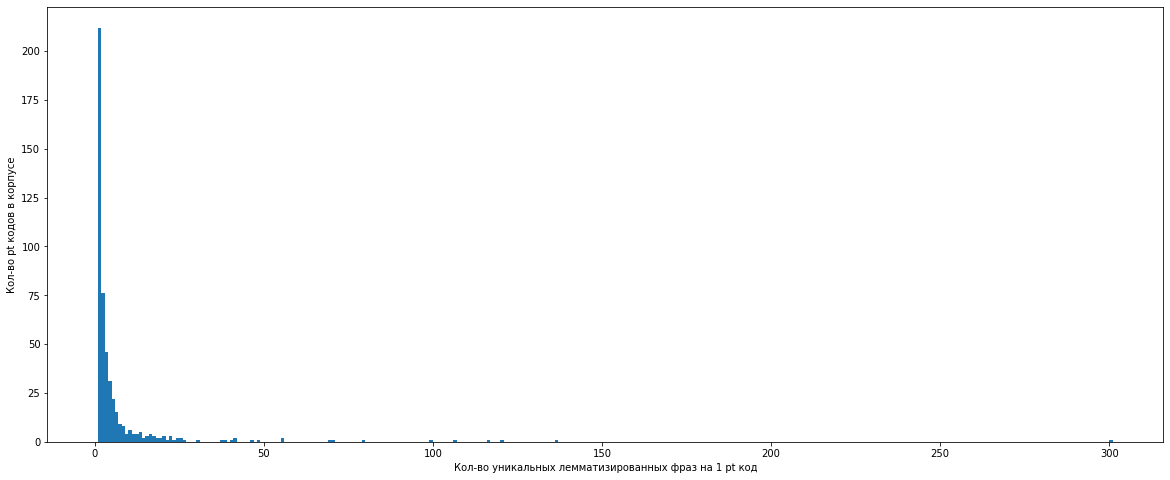

num uniq meddra codes: 490
num uniq phrases: 3263
avg num phrases per code: 6.7122448979591836


In [43]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='RDR (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

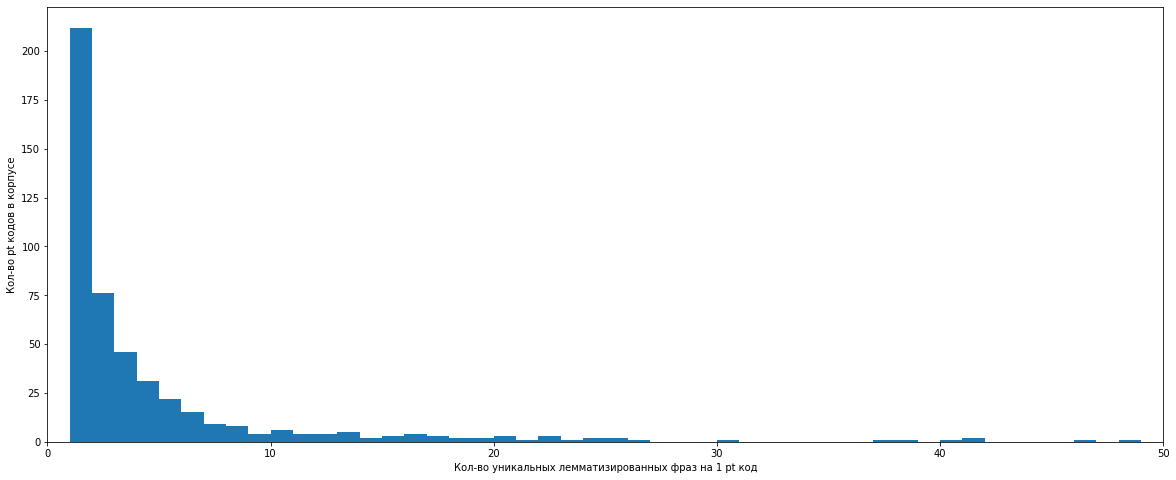

In [42]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize = (20,8), \
                           xlim = (0, 50), \
                           hist_fname='RDR (with lemmatization) xlim_right 50.png')

<h3>CADEC</h3>

In [15]:
data_dir = './Raw/CADEC/cadec_table_grartem.csv'

df = pd.read_csv('./Raw/CADEC/cadec_table_grartem.csv')


all_pt_ids = df['meddra'].to_list()
all_pt_phrases = df['term'].to_list()

In [16]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

In [17]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 6318


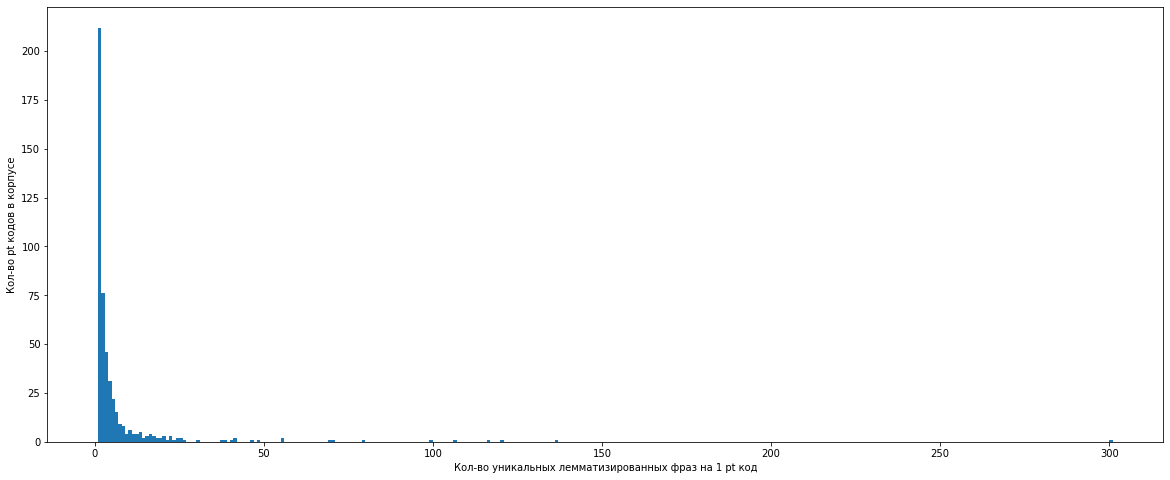

num uniq meddra codes: 490
num uniq phrases: 3263
avg num phrases per code: 6.7122448979591836


In [51]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='CADEC (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

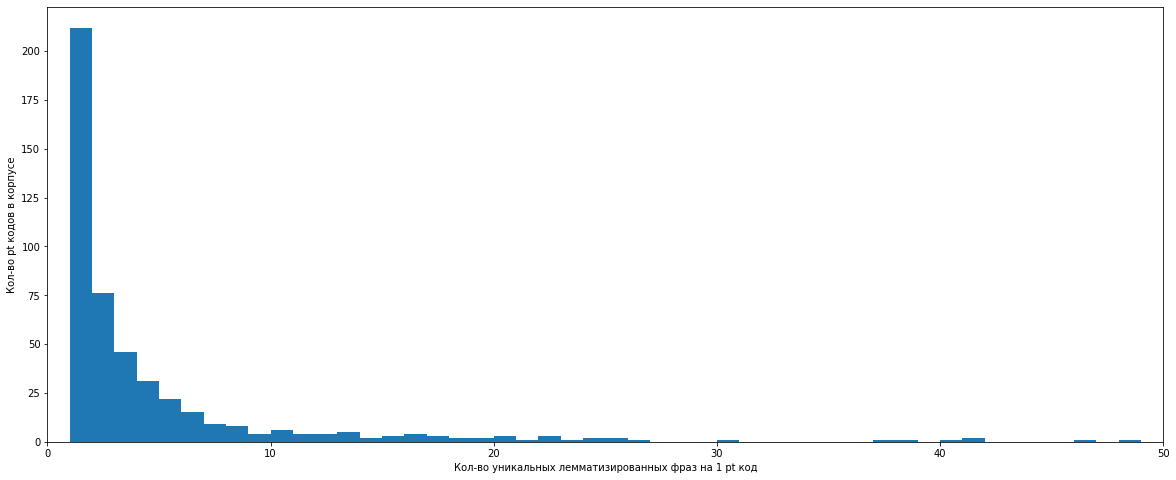

In [50]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           xlim = (0, 50), \
                           hist_fname='CADEC (with lemmatization) xlim_right 50.png')

<h3>MedMention</h3>

In [18]:
data_dir = './Raw/MedMentions/full/data/'

all_txt_ids = []
all_pt_ids = []
all_pt_phrases = []

no_matched_umls_codes = []

with open(data_dir+'corpus_pubtator.txt') as f:
    for line in f:
        if line.find('|')>0 or line=='\n':
            continue
        row_inf = line.split('\t')
        umls_id = row_inf[-1][:-1]
        curr_text_id = row_inf[0]
        phrase = row_inf[3]
        pt_code = mh_en.force_umlscode_to_ptcode(umls_id)
        if pt_code:
            all_pt_ids.append(pt_code)
        else:
            no_matched_umls_codes.append(umls_id)
            continue
        all_txt_ids.append(curr_text_id)
        all_pt_phrases.append(phrase)

In [19]:
print('len no matched umls codes: %s'%len(no_matched_umls_codes))
print('len matched umls codes: %s'%len(all_pt_phrases))
#если использовать только pt коды, то len no matched umls codes: 322985

len no matched umls codes: 315814
len matched umls codes: 36682


In [20]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 36682


In [45]:
len(mh_en.umlscode_to_ptcode)

22759

In [54]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

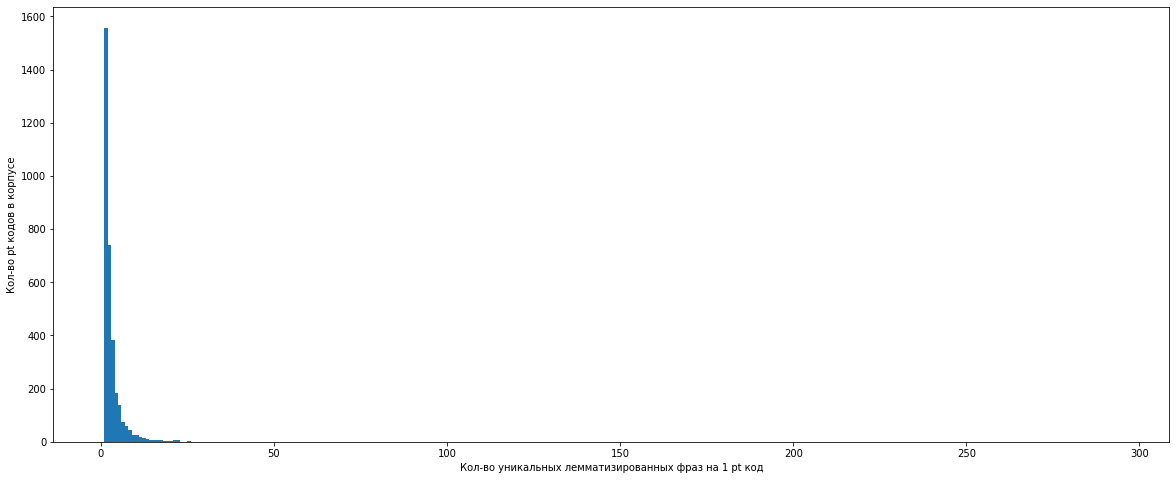

num uniq meddra codes: 3329
num uniq phrases: 9215
avg num phrases per code: 2.9191949534394714


In [58]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='MedMentions translated in pt codes (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

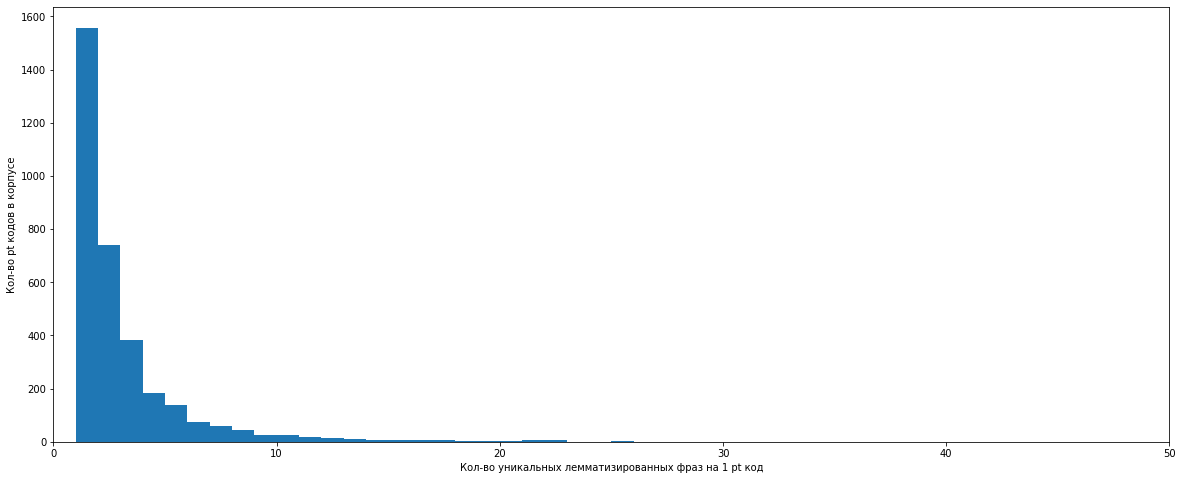

In [57]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           xlim=(0,50), \
                           hist_fname='MedMentions translated in pt codes (with lemmatization) xlim_right 30.png')

In [40]:
most_freq_codes = get_most_freq_codes(bins, stat_d)

In [41]:
[mh_en.ptcode_to_pt[code] for code in most_freq_codes]

['Laboratory test']

<h3>PsyTar origin (из коробки, без моей обработки и токенизации)</h3>

In [21]:
df = pd.read_excel("./Raw/PsyTAR_origin/PsyTAR_dataset.xlsx", sheet_name=None, engine='openpyxl')
df = {'ADRs': df['ADR_Mapped'], 'WDs': df['WD-Mapped '], 'SSI': df['SSI_Mapped'], 'DIs': df['DI_Mapped']}

In [22]:
all_pt_ids = []
all_pt_phrases = []


for k in df:
    #df[k] = df[k].apply(lambda x: re.sub('\s+', '', x[x.name].split('/')[0]) if x.name == 'UMLS1' or x.name == 'UMLS2' else x)
    df[k]['UMLS1'] = df[k]['UMLS1'].apply(lambda x: re.sub('\s+', '', x.split('/')[0].upper()))
    df[k]['UMLS2'] = df[k]['UMLS2'].apply(lambda x: re.sub('\s+', '', x.split('/')[0].upper()) if pd.notna(x) else x)
    #из двух umls выбираем тот, у которого есть pt код
    df[k]['UMLS'] = df[k]['UMLS1']
    mask_no_pt_codes = df[k]['UMLS1'].apply(lambda x: False if mh_en.force_umlscode_to_ptcode(x) else True)
    #заменили на UMLS2 у которого может быть pt code, если UMLS2 нет, тогда ставится NaN
    df[k].loc[mask_no_pt_codes, 'UMLS'] = df[k]['UMLS2'][mask_no_pt_codes]
    df[k]['pt_meddra'] = df[k]['UMLS'].apply(lambda x: mh_en.force_umlscode_to_ptcode(x))
    df[k] = df[k][df[k]['pt_meddra'].notna()]
    pt_ids = df[k]['pt_meddra'].to_list()
    phrases_li = df[k][k].to_list()
    
    all_pt_phrases.extend(phrases_li)
    all_pt_ids.extend(pt_ids)
    
print(all_pt_phrases[700:710])
print(all_pt_ids[700:710])
print([mh_en.ptcode_to_pt[code] for code in all_pt_ids[700:710]])

['some sleepiness ', 'excessive yawning', 'at first, headache', 'at first, nausea', 'at first, trembling belly', 'at first, loss of appetite', 'vivid dreams ', 'nightmares', 'libido is low', 'low sex drive']
['10022437', '10048232', '10019211', '10028813', '10000059', '10061428', '10000125', '10029412', '10024419', '10024419']
['Insomnia', 'Yawning', 'Headache', 'Nausea', 'Abdominal discomfort', 'Decreased appetite', 'Abnormal dreams', 'Nightmare', 'Libido decreased', 'Libido decreased']


In [23]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

In [24]:
print('num concepts: %s'%len(all_pt_ids))

num concepts: 6300


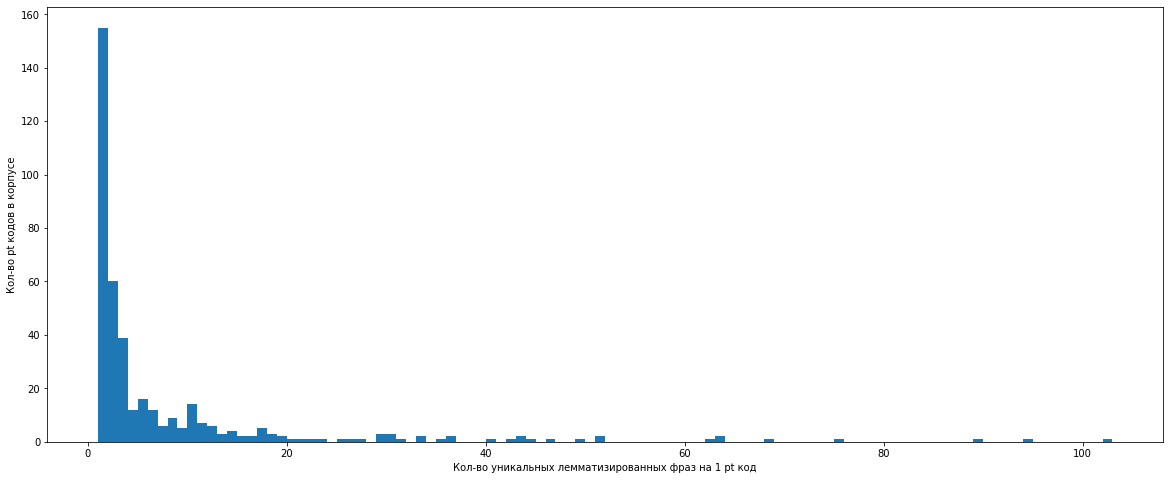

num uniq meddra codes: 398
num uniq phrases: 2923
avg num phrases per code: 7.399497487437186


In [63]:
N, bins, pathes = get_hist(stat_d, n_bins = 'auto', \
                           figsize=(20,8), \
                           hist_fname='PsyTar translated in pt codes (with lemmatization).png')
count_uniq_codes_and_phrases(all_pt_phrases)
avg_num_phrases_per_code(stat_d)

<h3>MedNorm</h3>

In [170]:
#По сути MedNorm это объединение и компиляция 5 датасетов, некоторые из которых уже были предствалены
#Это CADEC, TwADR-L, TwiMed, SMM4H 2017, TAC 2017


df = pd.read_csv('./Raw/MedNorm/mednorm_full.tsv', sep='\t')

#pd.to_numeric(df['meddra_code'], downcast='integer', errors='ignore')
df['pt_id'] = df['meddra_code'].apply(lambda x: str(int(x)) if pd.notna(x) else x)


mask_not_matched_pt_ids = df['meddra_code'].isna()
df.loc[mask_not_matched_pt_ids, 'pt_id'] = df['single_mapped_meddra_codes'][mask_not_matched_pt_ids]

all_pt_ids = df['pt_id'].tolist()
all_pt_phrases = df['phrase'].tolist()

print(all_pt_phrases[700:710])
print(all_pt_ids[700:710])
#print([mh_en.ptcode_to_pt[code] for code in all_pt_ids[700:710]])

errors = 0
for code in all_pt_ids:
    if code in mh_en.ptcodes or code in mh_en.lltcode_to_ptcode.keys():
        pass
    else:
        errors+=1
#df.loc[:, 'pt_id'] = pd.to_numeric(df['pt_id'], downcast='integer', errors='ignore')
errors

['Elevated blood pressure', 'acid reflux-type symptoms', 'heart palpitations', 'nausea', 'dizzy', 'Extreme gas in stomach and intestines', 'stomach pain', 'dizziness', 'pain in major joints', 'numbness in both legs']
['10020772', '10000479', '10033557', '10028813', '10013573', '10016766', '10042076', '10013573', '10003239', '10029850']


7302

In [136]:
stat_d = count_representativeness(all_pt_ids, all_pt_phrases)

27979